# Parity study

# What does `XOR` have to do with parity?

As noted on [Wikipedia][1], parity, in this context, refers to,

> ...the evenness or oddness of the number of bits with value one within a given set of bits...It can be calculated via an XOR sum of the bits, yielding 0 for even parity and 1 for odd parity.


[1]: https://en.wikipedia.org/wiki/Parity_bit#Parity

Now that we have an understanding of the problem, let's start by solving the **first problem**:
> Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?

In [1]:
from models import LSTM
from utils import train
from utils import create_loss_plot

import torch
import torch.optim as optim

In [2]:
from utils import create_parity_data

## Fixed sequence lengths.

In [3]:
num_iters = 2000
batch_size = 32

inputs, outputs = create_parity_data()

model = LSTM()
losses = train(
        model, 
        torch.FloatTensor(inputs).unsqueeze(-1), 
        torch.FloatTensor(outputs).unsqueeze(-1), 
        optim.RMSprop(model.parameters()), 
        num_iters, 
        batch_size
    )

### Plot the training loss.

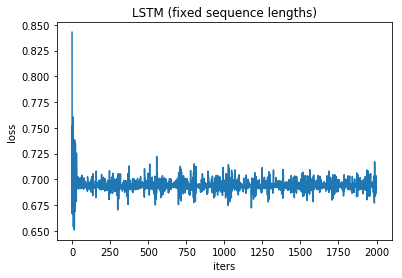

In [4]:
# Plot losses
title = 'LSTM (fixed sequence lengths)'
create_loss_plot(losses, title)

## Weird....
Despite playing with the hyperparameters and testing larger models, no model is learning. 

Interestingly, **changing the original problem slightly** allows even the simplest model to learn:

> **parity:** the evenness or oddness of the number ~~of bits with value one within a given set of bits~~ represented by the binary string

Somehow the modified problem is either simpler or more suitable for the proposed architecture.

## Modified parity problem for fixed length experiments.

### Create the data.

In [30]:
def create_simpler_data():
    num_examples = 100000
    seq_len = 50
    bits = [0, 1]
    
    inputs = []
    outputs = []
    for _ in xrange(num_examples):            
        seq = [random.choice(bits) for _ in xrange(seq_len)]
        
        # Modifiy the parity to match our new definition
        seq_str = ''.join(map(str, seq))
        value = int(seq_str, base=2)
        parity = int(value % 2 == 0)
        
        inputs.append(seq)
        outputs.append(parity)
    return inputs, outputs

In [31]:
# Create binary sequences of length 50.
simple_inputs, simple_outputs = create_simpler_data()

### Train the LSTM.

In [32]:
model = Model(hidden_size=1)
losses = train(simple_inputs, simple_outputs, model, optim.RMSprop(model.parameters()), num_iters, batch_size)

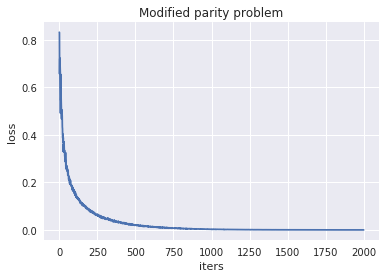

In [33]:
# Plot losses
title = 'Modified parity problem'
create_loss_plot(losses, title)

### Test accuracy.

In [34]:
def evaluate(inputs, outputs, model):
    X = torch.FloatTensor(inputs).unsqueeze(-1)
    y = torch.FloatTensor(outputs).unsqueeze(-1)

    X = Variable(X, requires_grad=True)
    y = Variable(y)

    predicitons = model(X)
    predicitons = np.around(predicitons.data.numpy())

    count = (predicitons == y.data.numpy()).sum()

    num_examples = len(X)
    accuracy = count / float(num_examples)

    return accuracy   

In [35]:
test_inputs, test_outputs = create_simpler_data()
print evaluate(test_inputs, test_outputs, model)

1.0


## Back to the original fixed length experiments.

It looks like we can train the model on shorter length sequences and it will generalize to much longer lengths.

In [11]:
v = Variable(torch.Tensor([[1,2],[3,4]]))

In [3]:
inputs, outputs = create_parity_data(fixed=False)

In [51]:
from utils import pad_seqs

In [52]:
inputs, seq_lens = pad_seqs(sorted(inputs, key=lambda seq: len(seq), reverse=True))

In [53]:
from torch.nn.utils.rnn import pack_padded_sequence

In [54]:
from torch.autograd import Variable

In [8]:
torch.FloatTensor(inputs)

RuntimeError: inconsistent sequence length at index (1, 49) - expected 50 but got 32

In [56]:
inputs = pack_padded_sequence(Variable(torch.FloatTensor(inputs).unsqueeze(-1), requires_grad=True), seq_lens, batch_first=True)

In [58]:
import numpy as np

In [59]:
idx = np.random.randint(len(outputs), size=32)

In [60]:
model.Cell

LSTM(1, 1, batch_first=True)

In [4]:
model = LSTM()
losses = train(
        model,
        torch.FloatTensor(inputs).unsqueeze(-1), 
        torch.FloatTensor(outputs).unsqueeze(-1),  
        optim.RMSprop(model.parameters()), 
        2000,
        batch_size=1
    )

RuntimeError: inconsistent sequence length at index (1, 49) - expected 50 but got 32

# I have the feeling that i should pack batches 
rather than create batches from a packed seq

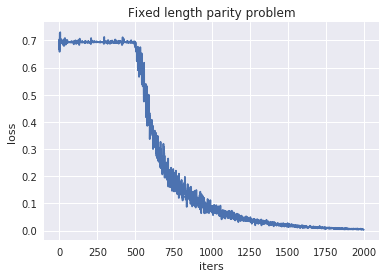

In [56]:
title = 'Fixed length parity problem'
create_loss_plot(losses, title)

In [57]:
test_inputs, test_outputs = create_data(num_examples=60000, max_seq_len=50, fixed_seq_len=True)
print evaluate(test_inputs, test_outputs, model)

1.0


# TODO:
  * are the weights interpretable?
  * intuitive terms/understadning as to why it struggles with long seq lens -> would a human and why?
  * training on seq len of 2 generalizes almost perfectly, what!
  * random search over weight space as proposed in bengio paper work?
  * how does this behavior compare with a vanilla rnn?

In [10]:
m = LSTM()

<bound method LSTM.train of LSTM(
  (Cell): LSTM(1, 1, batch_first=True)
  (Linear): Linear(in_features=1, out_features=1)
  (Sigmoid): Sigmoid()
)>